In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, fft

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif",
})

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

xlabel_kwargs = {"fontsize":15}
ylabel_kwargs = {"fontsize":15}
legend_kwargs = {"fontsize":12}
title_kwargs = {"fontsize":18}

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.ae_v3 import Autoencoder

In [8]:
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)

if colab_flag == False:
    if strategy is None:
#         if gpus:
#             gpu_to_use = 1
        tf.config.set_visible_devices([], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[]


2023-08-06 07:36:32.774198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 07:36:32.845410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 07:36:32.845702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 07:36:32.847230: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [9]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.8.1


# KS System

In [10]:
prng_seed = 42
np.random.seed(prng_seed)

train_split = 0.8
val_split = 0.1
test_split = 0.1

In [11]:
from numpy import *

data_dir_idx = '008'

dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data_og = fl['all_data'].astype(FTYPE)
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

num_params = params_mat.shape[1]
og_vars = all_data_og.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

normalize_flag_ogdata: False


In [12]:
num_train = int(all_data_og.shape[0]*train_split)
num_val = int(all_data_og.shape[0]*val_split)
num_test = all_data_og.shape[0] - num_train - num_val

idx = np.arange(all_data_og.shape[0])
# np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)

training_data[:] = all_data_og[idx[0:num_train]]
val_data[:] = all_data_og[idx[num_train:num_train+num_val]]
testing_data[:] = all_data_og[idx[num_train+num_val:]]

In [13]:
print('training_data.shape : ', training_data.shape)
print('val_data.shape : ', val_data.shape)
print('testing_data.shape : ', testing_data.shape)

training_data.shape :  (80000, 3)
val_data.shape :  (10000, 3)
testing_data.shape :  (10001, 3)


In [14]:
# training data
FourierCoeffs_trainingdata = fft.fft(training_data[:, 0:og_vars], axis=1)
energySpectrum_og_trainingdata = FourierCoeffs_trainingdata.real**2 + FourierCoeffs_trainingdata.imag**2
energySpectrum_og_trainingdata = np.mean(energySpectrum_og_trainingdata, axis=0)

# testing data
FourierCoeffs_testingdata = fft.fft(testing_data[:, 0:og_vars], axis=1)
energySpectrum_og_testingdata = FourierCoeffs_testingdata.real**2 + FourierCoeffs_testingdata.imag**2
energySpectrum_og_testingdata = np.mean(energySpectrum_og_testingdata, axis=0)

In [15]:
# training data
meancentereddata_og_trainingdata = training_data[:, 0:og_vars] - np.mean(training_data[:, 0:og_vars], axis=0)
covmat_og_trainingdata = np.matmul(meancentereddata_og_trainingdata.transpose(), meancentereddata_og_trainingdata) / (meancentereddata_og_trainingdata.shape[0] - 1)
eigvals_og_trainingdata = np.abs(np.linalg.eigvals(covmat_og_trainingdata))
eigvals_og_trainingdata = np.sort(eigvals_og_trainingdata)
eigvals_og_trainingdata = eigvals_og_trainingdata[::-1]

# testing data
meancentereddata_og_testingdata = testing_data[:, 0:og_vars] - np.mean(testing_data[:, 0:og_vars], axis=0)
covmat_og_testingdata = np.matmul(meancentereddata_og_testingdata.transpose(), meancentereddata_og_testingdata) / (meancentereddata_og_testingdata.shape[0] - 1)
eigvals_og_testingdata = np.abs(np.linalg.eigvals(covmat_og_testingdata))
eigvals_og_testingdata = np.sort(eigvals_og_testingdata)
eigvals_og_testingdata = eigvals_og_testingdata[::-1]

In [16]:
# training data
print('eigvals sum (training data) : ', np.sum(eigvals_og_trainingdata))
print('FC sum (training data) : ', np.sum(energySpectrum_og_trainingdata))

# testing data
print('\neigvals sum (testing data) : ', np.sum(eigvals_og_testingdata))
print('FC sum (testing data) : ', np.sum(energySpectrum_og_testingdata))

eigvals sum (training data) :  219.00643758046982
FC sum (training data) :  2314.9965173342534

eigvals sum (testing data) :  218.24283
FC sum (testing data) :  2326.6605246174613


In [17]:
dir_name_all_ae = os.getcwd()+'{ds}saved_ae'.format(ds=dir_sep)
# dir_contents_list = os.listdir(dir_name_all_ae)
# chosen_dir_list = []
# for elem in dir_contents_list:
#     dir_name_ae = dir_name_all_ae + dir_sep + elem
#     if os.path.isdir(dir_name_ae):
#         with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
#             lines = f.readlines()
#             params_dict = eval(''.join(lines))
#             if data_dir_idx == params_dict['data_dir_idx']:
#                 chosen_dir_list.append(elem)

chosen_dir_list = [
    'ae_024',
    'test_ae_020',
]
print('chosen_dir_list:', chosen_dir_list)

chosen_dir_list: ['ae_024', 'test_ae_020']


In [18]:
# making AR-RNN save directory
dir_name_aepod = os.getcwd() + dir_sep + 'saved_ae/ae_contractive_vs_normal'
if not os.path.isdir(dir_name_aepod):
    os.makedirs(dir_name_aepod)

counter = 0
while True:
    dir_check = 'ae_contractive_normal_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_aepod + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_aepod = dir_name_aepod + dir_sep + dir_check
os.makedirs(dir_name_aepod)

dir_name_plot = dir_name_aepod+dir_sep+'plots'
os.makedirs(dir_name_plot)

In [19]:
print(dir_name_aepod)

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_contractive_vs_normal/ae_contractive_normal_002


In [20]:
num_latent_states_list = []

timeAvgEnergySpectrum = []
covmat_list_AE = []
eigvals_list_AE = []
latent_states_covmat_list = []
latent_states_eigenvals_list = []

latent_states_rmsval = []

AE_recon_MSE_lst = []
AE_recon_RMSE_lst = []
AE_recon_NMSE_lst = []
AE_recon_NRMSE_lst = []

contractive_or_not = []
ls_jacob_normed = []

for elem in chosen_dir_list:
    time_taken = time.time()
    print('\n\n-------------------- {} --------------------'.format(elem))
    dir_name_ae = dir_name_all_ae + dir_sep + elem
    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        ae_data_with_params = params_dict['ae_data_with_params']
    except:
        print("'ae_data_with_params' not present in ae_data, set to 'True'.")
        ae_data_with_params = True

    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
    
    # dealing with normalizing the data before feeding into autoencoder
    # all_data = all_data_og
    training_data_thiselem = training_data
    testing_data_thiselem = testing_data
    if normalizeforae_flag == True:
        training_data_thiselem = np.empty_like(training_data)
        training_data_thiselem[:] = training_data[:]
        for i in range(og_vars):
            training_data_thiselem[:, i] -= normalization_constant_arr_aedata[0, i]
            training_data_thiselem[:, i] /= normalization_constant_arr_aedata[1, i]

        testing_data_thiselem = np.empty_like(testing_data)
        testing_data_thiselem[:] = testing_data[:]
        for i in range(og_vars):
            testing_data_thiselem[:, i] -= normalization_constant_arr_aedata[0, i]
            testing_data_thiselem[:, i] /= normalization_constant_arr_aedata[1, i]
    if ae_data_with_params == False:
        training_data_thiselem = training_data_thiselem[:, 0:og_vars]
        testing_data_thiselem = testing_data_thiselem[:, 0:og_vars]
    
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

    ae_net = Autoencoder(testing_data_thiselem.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)
    
    if ae_net.contractive_lmda == 0.:
        contractive_or_not.append(False)
    else:
        contractive_or_not.append(True)

    # create data
    latent_states_all_trainingdata = ae_net.encoder_net.predict(training_data_thiselem)
    latent_states_all_testingdata = ae_net.encoder_net.predict(testing_data_thiselem)
    num_latent_states = latent_states_all_trainingdata.shape[1]
    num_latent_states_list.append(num_latent_states)
    
    ls_jacob_normed_trainingdata = ae_net.compute_normed_grad(tf.constant(training_data_thiselem))
    ls_jacob_normed_testingdata = ae_net.compute_normed_grad(tf.constant(testing_data_thiselem))
    ls_jacob_normed.append([ls_jacob_normed_trainingdata, ls_jacob_normed_testingdata])    
    
    ls_rmsval = []
    ls_rmsval.append(np.mean(np.mean(latent_states_all_trainingdata**2, axis=1)**0.5))
    ls_rmsval.append(np.mean(np.mean(latent_states_all_testingdata**2, axis=1)**0.5))
    latent_states_rmsval.append(ls_rmsval)
    
    reconstructed_data_trainingdata = ae_net.decoder_net.predict(latent_states_all_trainingdata)
    reconstructed_data_testingdata = ae_net.decoder_net.predict(latent_states_all_testingdata)

    if normalizeforae_flag == True:
        for i in range(og_vars):
            reconstructed_data_trainingdata[:, i] *= normalization_constant_arr_aedata[1, i]
            reconstructed_data_trainingdata[:, i] += normalization_constant_arr_aedata[0, i]
            training_data_thiselem[:, i] *= normalization_constant_arr_aedata[1, i]
            training_data_thiselem[:, i] += normalization_constant_arr_aedata[0, i]
            
            reconstructed_data_testingdata[:, i] *= normalization_constant_arr_aedata[1, i]
            reconstructed_data_testingdata[:, i] += normalization_constant_arr_aedata[0, i]
            testing_data_thiselem[:, i] *= normalization_constant_arr_aedata[1, i]
            testing_data_thiselem[:, i] += normalization_constant_arr_aedata[0, i]

    FourierCoeffs = []
    FourierCoeffs.append(fft.fft(reconstructed_data_trainingdata[:, 0:og_vars], axis=1))
    FourierCoeffs.append(fft.fft(reconstructed_data_testingdata[:, 0:og_vars], axis=1))
    energySpectrum = []
    energySpectrum.append(np.mean(FourierCoeffs[0].real**2 + FourierCoeffs[0].imag**2, axis=0))
    energySpectrum.append(np.mean(FourierCoeffs[1].real**2 + FourierCoeffs[1].imag**2, axis=0))
    timeAvgEnergySpectrum.append(energySpectrum)

    meancentereddata_ae = []
    meancentereddata_ae.append(reconstructed_data_trainingdata[:, 0:og_vars] - np.mean(reconstructed_data_trainingdata[:, 0:og_vars], axis=0))
    meancentereddata_ae.append(reconstructed_data_testingdata[:, 0:og_vars] - np.mean(reconstructed_data_testingdata[:, 0:og_vars], axis=0))
    covmat_ae = []
    covmat_ae.append(np.matmul(meancentereddata_ae[0].transpose(), meancentereddata_ae[0]) / (meancentereddata_ae[0].shape[0] - 1))
    covmat_ae.append(np.matmul(meancentereddata_ae[1].transpose(), meancentereddata_ae[1]) / (meancentereddata_ae[1].shape[0] - 1))
    eigvals_ae = []
    eigvals_ae.append(np.sort(np.abs(np.linalg.eigvals(covmat_ae[0])))[::-1])
    eigvals_ae.append(np.sort(np.abs(np.linalg.eigvals(covmat_ae[1])))[::-1])
    covmat_list_AE.append(covmat_ae)
    eigvals_list_AE.append(eigvals_ae)
    
    meancentered_ls = []
    meancentered_ls.append(latent_states_all_trainingdata - np.mean(latent_states_all_trainingdata, axis=0))
    meancentered_ls.append(latent_states_all_testingdata - np.mean(latent_states_all_testingdata, axis=0))
    covmat_ls = []
    covmat_ls.append(np.matmul(meancentered_ls[0].transpose(), meancentered_ls[0]) / (meancentered_ls[0].shape[0] - 1))
    covmat_ls.append(np.matmul(meancentered_ls[1].transpose(), meancentered_ls[1]) / (meancentered_ls[1].shape[0] - 1))
    eigvals_ls = []
    eigvals_ls.append(np.sort(np.abs(np.linalg.eigvals(covmat_ls[0])))[::-1])
    eigvals_ls.append(np.sort(np.abs(np.linalg.eigvals(covmat_ls[1])))[::-1])
    latent_states_covmat_list.append(covmat_ls)
    latent_states_eigenvals_list.append(eigvals_ls)

    reconstruction_MSE = []
    reconstruction_MSE.append((reconstructed_data_trainingdata - training_data_thiselem)**2)
    reconstruction_MSE.append((reconstructed_data_testingdata - testing_data_thiselem)**2)
    stddev_data = []
    stddev_data.append(np.std(training_data_thiselem, axis=0))
    stddev_data.append(np.std(testing_data_thiselem, axis=0))
    normalized_recon_MSE = []
    normalized_recon_MSE.append(np.average(reconstruction_MSE[0]/stddev_data[0]**2, axis=1))
    normalized_recon_MSE.append(np.average(reconstruction_MSE[1]/stddev_data[0]**2, axis=1))
    normalized_recon_RMSE = []
    normalized_recon_RMSE.append(np.average(normalized_recon_MSE[0]**0.5, axis=0))
    normalized_recon_RMSE.append(np.average(normalized_recon_MSE[1]**0.5, axis=0))
    normalized_recon_MSE[0] = np.average(normalized_recon_MSE[0], axis=0)
    normalized_recon_MSE[1] = np.average(normalized_recon_MSE[1], axis=0)
    reconstruction_MSE[0] = np.average(reconstruction_MSE[0], axis=1)
    reconstruction_MSE[1] = np.average(reconstruction_MSE[1], axis=1)
    reconstruction_RMSE = []
    reconstruction_RMSE.append(np.average(reconstruction_MSE[0]**0.5, axis=0))
    reconstruction_RMSE.append(np.average(reconstruction_MSE[1]**0.5, axis=0))
    reconstruction_MSE[0] = np.average(reconstruction_MSE[0], axis=0)
    reconstruction_MSE[1] = np.average(reconstruction_MSE[1], axis=0)
    
    AE_recon_MSE_lst.append(reconstruction_MSE)
    AE_recon_RMSE_lst.append(reconstruction_RMSE)
    AE_recon_NMSE_lst.append(normalized_recon_MSE)
    AE_recon_NRMSE_lst.append(normalized_recon_RMSE)
    
    del(latent_states_all_trainingdata)
    del(latent_states_all_testingdata)
    del(reconstructed_data_trainingdata)
    del(reconstructed_data_testingdata)
    
    time_taken = time.time() - time_taken
    print('time_taken : {:02d}h {:02d}m {:02d}s'.format(
        int(time_taken//3600),
        int((time_taken%3600)//60),
        int(time_taken%60),
    ))



-------------------- ae_024 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.


2023-08-06 07:36:37.165685: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25600000000 exceeds 10% of free system memory.


time_taken : 00h 00m 10s


-------------------- test_ae_020 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.


2023-08-06 07:36:47.325573: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25600000000 exceeds 10% of free system memory.


time_taken : 00h 00m 10s


In [21]:
sorted_idx = np.argsort(num_latent_states_list)

num_latent_states_list = np.array(num_latent_states_list)[sorted_idx]
timeAvgEnergySpectrum = np.array(timeAvgEnergySpectrum)[sorted_idx]
covmat_list_AE = np.array(covmat_list_AE)[sorted_idx]
eigvals_list_AE = np.array(eigvals_list_AE)[sorted_idx]
chosen_dir_list = np.array(chosen_dir_list)[sorted_idx]
AE_recon_MSE_lst = np.array(AE_recon_MSE_lst)[sorted_idx]
AE_recon_RMSE_lst = np.array(AE_recon_RMSE_lst)[sorted_idx]
AE_recon_NMSE_lst = np.array(AE_recon_NMSE_lst)[sorted_idx]
AE_recon_NRMSE_lst = np.array(AE_recon_NRMSE_lst)[sorted_idx]

temp1 = []
temp2 = []
for i in range(len(sorted_idx)):
    temp1.append(latent_states_covmat_list[sorted_idx[i]])
    temp2.append(latent_states_eigenvals_list[sorted_idx[i]])
latent_states_covmat_list = temp1
latent_states_eigenvals_list = temp2

In [22]:
contractive_or_not = np.array(contractive_or_not)[sorted_idx]

In [23]:
latent_states_rmsval = np.array(latent_states_rmsval)[sorted_idx]

In [24]:
ls_jacob_normed = np.array(ls_jacob_normed)[sorted_idx]

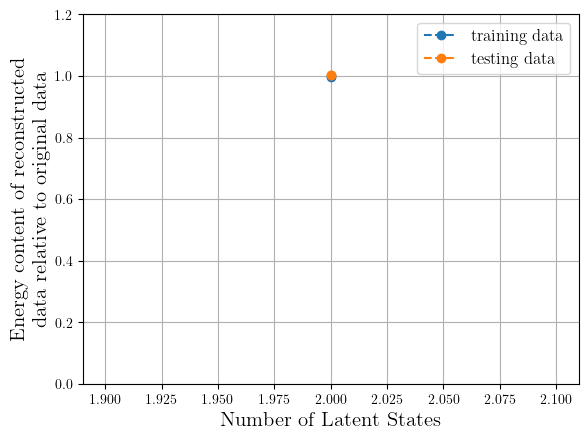

training data :  [0.99969616 0.99765031]
 testing data :  [1.00440211 1.00258786]


In [25]:
plt.plot(
    num_latent_states_list,
    np.sum(timeAvgEnergySpectrum[:, 0], axis=1)/np.sum(energySpectrum_og_trainingdata),
    '--', marker='o', label='training data')
plt.plot(
    num_latent_states_list,
    np.sum(timeAvgEnergySpectrum[:, 1], axis=1)/np.sum(energySpectrum_og_trainingdata),
    '--', marker='o', label='testing data')
plt.grid(True)
plt.xlabel('Number of Latent States', **xlabel_kwargs)
plt.ylabel('Energy content of reconstructed\ndata relative to original data', **xlabel_kwargs)
plt.ylim([0, 1.2])
plt.legend(**legend_kwargs)
plt.show()

print('training data : ', np.sum(timeAvgEnergySpectrum[:, 0], axis=1)/np.sum(energySpectrum_og_trainingdata))
print(' testing data : ', np.sum(timeAvgEnergySpectrum[:, 1], axis=1)/np.sum(energySpectrum_og_trainingdata))

100.0
100.0


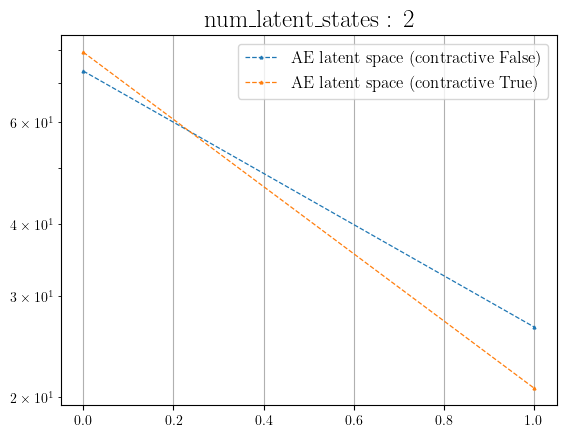

In [26]:
fig_eigvals, ax_eigvals = plt.subplots()
for i in range(len(chosen_dir_list)):
    # fig_eigvals, ax_eigvals = plt.subplots()
    # ax_eigvals.semilogy(eigvals_og/np.sum(eigvals_og), linestyle='--', marker='s', linewidth=0.9, markersize=2, label=r'Original Data')
    ax_eigvals.semilogy(
        100*latent_states_eigenvals_list[i][0]/np.sum(latent_states_eigenvals_list[i][0]),
        linestyle='--',
        marker='^',
        linewidth=0.9,
        markersize=2,
        label=r'AE latent space'+' (contractive {})'.format(contractive_or_not[i])
    )
    idx_end = 19
    if len(latent_states_eigenvals_list[i]) < idx_end:
        idx_end = len(latent_states_eigenvals_list[i][0])
    print(100*np.sum(latent_states_eigenvals_list[i][0][0:idx_end]/np.sum(latent_states_eigenvals_list[i][0])))
        
ax_eigvals.grid(True)
ax_eigvals.legend(**legend_kwargs)
ax_eigvals.set_axisbelow(True)
ax_eigvals.set_title('Eigenvalues of the covariance matrix', **title_kwargs)
plt.title('num_latent_states : {}'.format(num_latent_states_list[i]), **title_kwargs)
plt.show()

In [27]:
with open(dir_name_aepod+'/chosen_dirs.txt', 'w') as f:
    s = 'dir_name, num_latent_states\n'#, enc_filters, dec_filters/n'
    f.write(s)
    for i in range(len(chosen_dir_list)):
        s = chosen_dir_list[i] + ', ' + str(num_latent_states_list[i]) + ', ' + str(contractive_or_not[i]) +'\n'
        # s += ', ' + str(attention_used_list[i]) + ', ' + str(latent_states_shape_list[i]) + '\n'
        f.write(s)

# POD

In [28]:
# sorted_idx = np.argsort(eigenvals)
# eigenvals = eigenvals[sorted_idx]
# eigenvecs = eigenvecs[:, sorted_idx]

In [29]:
# print(eigenvals)

# for i in range(eigenvecs.shape[1]):
#     print('norm(ev[:, {}]) : {}'.format(i, np.sum(eigenvecs[:, i]**2)))

# Comparison of Time Averaged RMSE

In [30]:
num_latent_states_list

array([2, 2])

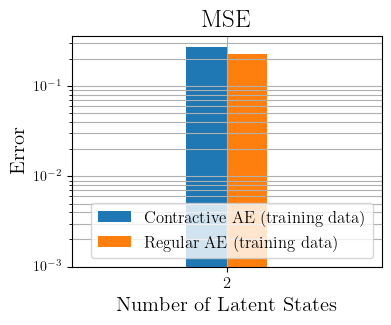

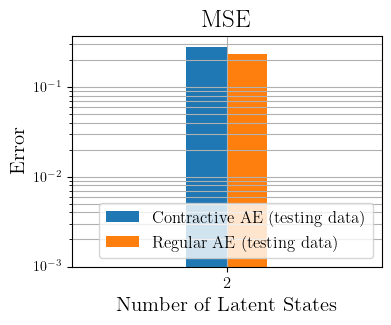

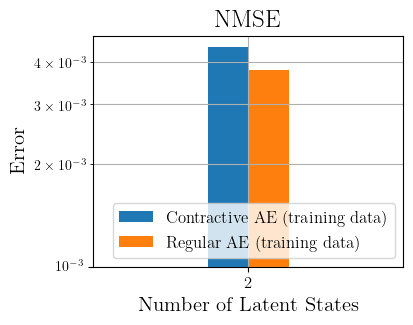

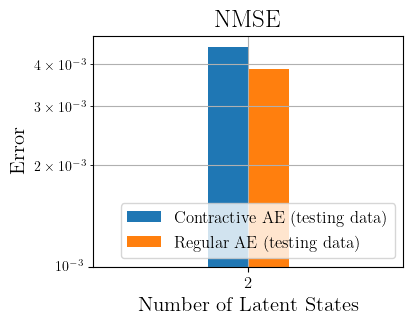

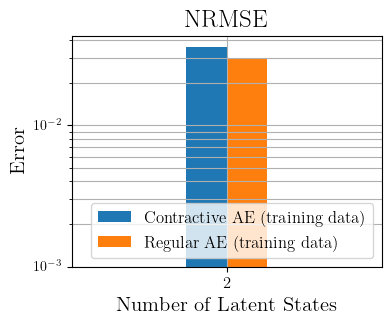

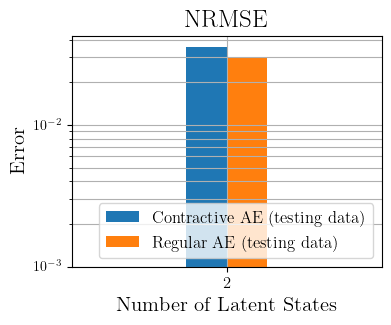

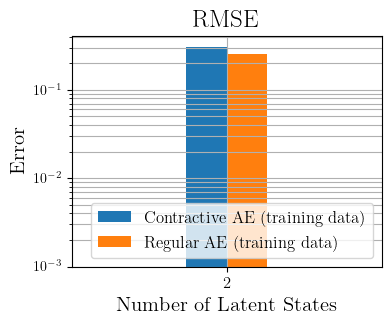

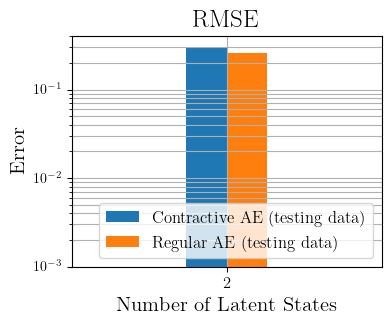

In [31]:
# reconstruction errors
error_type_list = ['MSE', 'NMSE', 'NRMSE', 'RMSE']
for jj in range(len(error_type_list)):
    error_type = error_type_list[jj]
    AE_error = eval('AE_recon_'+error_type+'_lst')
    # POD_error = eval('POD_recon_'+error_type+'_lst')

    width = 0.15
    ind = np.arange(num_latent_states_list.shape[0]-1)
    # ind = np.arange(contractive_or_not.shape[0])

    legend_suffix = [' (training data)', ' (testing data)']
    savename_suffix = ['--trainingdata', '---testingdata']
    for ii in range(2):
        # plt.bar(ind, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='AE')
        # plt.bar(ind+width, np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='POD')
        # plt.semilogy(num_latent_states_list, AE_error[:, ii], '--', marker='o', linewidth=0.9, label='AE'+legend_suffix[ii])
        # plt.semilogy(num_latent_states_list, POD_error[:, ii], '--', marker='o', linewidth=0.9, label='POD'+legend_suffix[ii])

        bottom_cutoff = np.min([1e-3, np.min(AE_error)])
        
        #label_prefix = 'Contractive ' if contractive_or_not[0] == True else 'Regular '
        plt.bar(ind, AE_error[contractive_or_not, ii], width, label='Contractive AE'+legend_suffix[ii], bottom=bottom_cutoff)
        plt.bar(ind+width, AE_error[np.logical_not(contractive_or_not), ii], width, label='Regular AE'+legend_suffix[ii], bottom=bottom_cutoff)
        plt.gca().set_yscale('log')
        plt.grid(True, which='both')
        plt.xlabel('Number of Latent States', **xlabel_kwargs)
        plt.ylabel('Error', **ylabel_kwargs)
        plt.title(error_type, **title_kwargs)
        plt.xticks(ind[0:1]+width/2, [r''+str(elem) for elem in num_latent_states_list[0:1]], **legend_kwargs)
        # plt.ylim([-0.05, 1.05])
        plt.xlim(-0.5, ind[-1]+width+0.5)
        plt.legend(**legend_kwargs, loc='lower right')
        
        plt.gcf().set_size_inches(4,3)

        plt.savefig(dir_name_plot+'/AE_contractive_vs_not_'+error_type+savename_suffix[ii]+'.pdf', dpi=300, bbox_inches='tight')
        plt.show()

        with open(dir_name_aepod+'/AE_contractive_vs_not_'+error_type+savename_suffix[ii]+'.txt', 'w') as f:
            s =  'num_latent_states : '
            temp_lst = ["{:02d}".format(elem) for elem in num_latent_states_list]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '      contractive : '
            temp_lst = ["{}".format(elem) for elem in contractive_or_not]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '               AE : '
            temp_lst = ["{:.4E}".format(elem) for elem in AE_error[:, ii]]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '              POD : '
            f.write(s)
        plt.close()

In [32]:
latent_states_eigenvals_list

[[array([0.02514003, 0.00904905]),
  array([0.02525277, 0.00889675], dtype=float32)],
 [array([0.00855797, 0.0022385 ]),
  array([0.00858349, 0.00219664], dtype=float32)]]

In [33]:
for i in range(len(latent_states_covmat_list)):
    idx = sorted_idx[i]
    covmat_lst = latent_states_covmat_list[idx]
    print('contractive : {}'.format(contractive_or_not[idx]))
    
    new_covmat = np.empty_like(latent_states_covmat_list[idx][1])
    new_covmat[:, :] = latent_states_covmat_list[idx][1]
    
    for j in range(new_covmat.shape[0]):
        new_covmat[j] /= new_covmat[j, j]
        
    print(new_covmat)
    print(np.sum([latent_states_covmat_list[idx][1][j, j] for j in range(new_covmat.shape[0])]))
    print(np.sum(latent_states_eigenvals_list[idx][1]))
    print('')

contractive : False
[[1.         0.52423847]
 [0.4190836  1.        ]]
0.03414952
0.03414952

contractive : True
[[1.         0.7354011 ]
 [0.35633326 1.        ]]
0.0107801305
0.0107801305



In [34]:
latent_states_rmsval

array([[0.26865563, 0.26818225],
       [0.12715146, 0.12670916]], dtype=float32)

In [35]:
np.sum(latent_states_eigenvals_list, axis=-1)

array([[0.03418907, 0.03414952],
       [0.01079647, 0.01078013]])

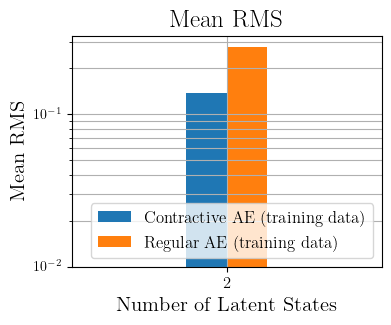

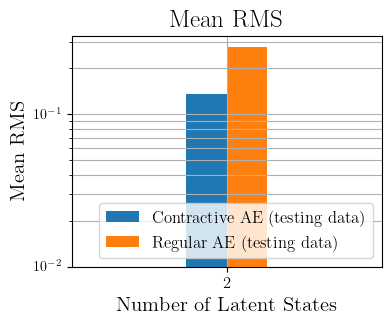

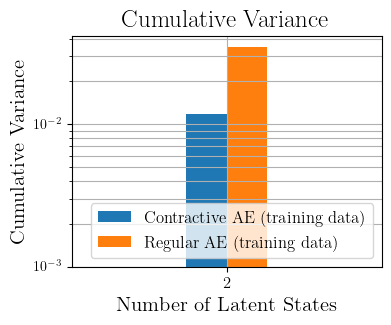

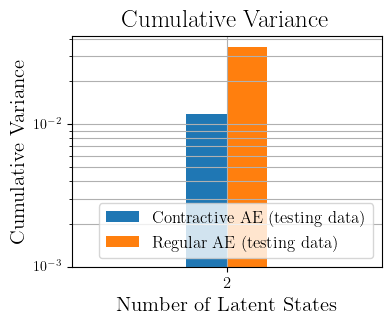

In [36]:
# variances
plot_list = ['Mean RMS', 'Cumulative Variance']
save_name = ['meanrms', 'totalvar']
plot_arr_list = [latent_states_rmsval, np.sum(latent_states_eigenvals_list, axis=-1)]

bc_arr = [1e-2, 1e-3]

for jj in range(len(plot_list)):
    # error_type = error_type_list[jj]
    AE_error = plot_arr_list[jj]
    
    width = 0.15
    ind = np.arange(num_latent_states_list.shape[0]-1)
    # ind = np.arange(contractive_or_not.shape[0])

    legend_suffix = [' (training data)', ' (testing data)']
    savename_suffix = ['--trainingdata', '---testingdata']
    for ii in range(2):
        # plt.bar(ind, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='AE')
        # plt.bar(ind+width, np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='POD')
        # plt.semilogy(num_latent_states_list, AE_error[:, ii], '--', marker='o', linewidth=0.9, label='AE'+legend_suffix[ii])
        # plt.semilogy(num_latent_states_list, POD_error[:, ii], '--', marker='o', linewidth=0.9, label='POD'+legend_suffix[ii])

        bottom_cutoff = np.min([bc_arr[jj], np.min(AE_error)])
        
        #label_prefix = 'Contractive ' if contractive_or_not[0] == True else 'Regular '
        plt.bar(ind, AE_error[contractive_or_not, ii], width, label='Contractive AE'+legend_suffix[ii], bottom=bottom_cutoff)
        plt.bar(ind+width, AE_error[np.logical_not(contractive_or_not), ii], width, label='Regular AE'+legend_suffix[ii], bottom=bottom_cutoff)
        plt.gca().set_yscale('log')
        plt.grid(True, which='both')
        plt.xlabel('Number of Latent States', **xlabel_kwargs)
        plt.ylabel(plot_list[jj], **ylabel_kwargs)
        plt.title(plot_list[jj], **title_kwargs)
        plt.xticks(ind[0:1]+width/2, [r''+str(elem) for elem in num_latent_states_list[0:1]], **legend_kwargs)
        # plt.ylim([-0.05, 1.05])
        plt.xlim(-0.5, ind[-1]+width+0.5)
        plt.legend(**legend_kwargs, loc='lower right')
        
        plt.gcf().set_size_inches(4,3)

        plt.savefig(dir_name_plot+'/AE_contractive_vs_not_'+save_name[jj]+savename_suffix[ii]+'.pdf', dpi=300, bbox_inches='tight')
        plt.show()

        with open(dir_name_aepod+'/AE_contractive_vs_not_'+save_name[jj]+savename_suffix[ii]+'.txt', 'w') as f:
            s =  'num_latent_states : '
            temp_lst = ["{:02d}".format(elem) for elem in num_latent_states_list]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '      contractive : '
            temp_lst = ["{}".format(elem) for elem in contractive_or_not]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '               AE : '
            temp_lst = ["{:.4E}".format(elem) for elem in AE_error[:, ii]]
            s += ', '.join(temp_lst)
            s += "\n"
            f.write(s)
        plt.close()

In [37]:
ls_jacob_normed

array([[[2.0029633 , 0.61512727],
        [1.992443  , 0.6155288 ]],

       [[2.5153134 , 0.28662387],
        [2.6233456 , 0.2873647 ]]], dtype=float32)

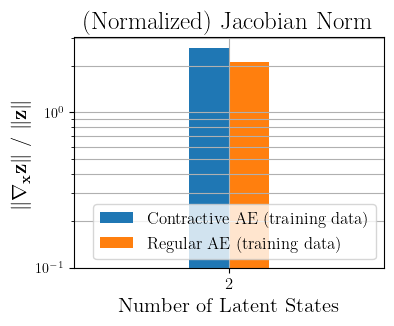

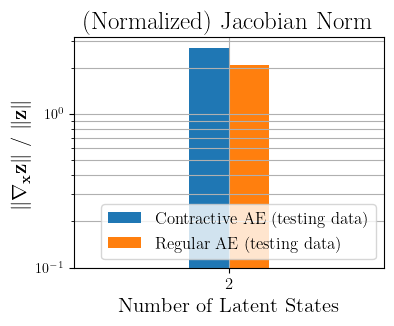

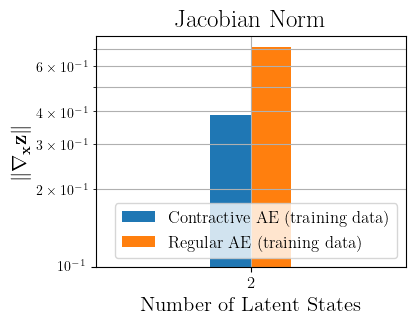

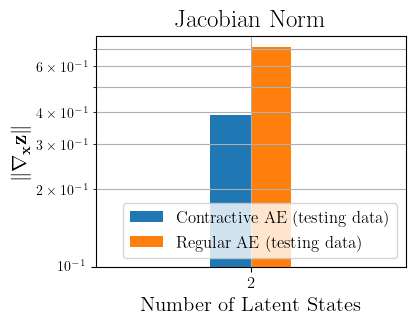

In [38]:
# variances
plot_list = ['(Normalized) Jacobian Norm', 'Jacobian Norm']
ylabel_list = [r'$\|\nabla_{\mathbf{x}} \mathbf{z} \| \ / \ \| \mathbf{z} \|$', r'$\|\nabla_{\mathbf{x}} \mathbf{z} \|$']
save_name = ['ls_jacob_norm', 'ls_jacob']
plot_arr_list = [ls_jacob_normed[:, :, 0], ls_jacob_normed[:, :, 1]]

bc_arr = [1e-1, 1e-1]

for jj in range(len(plot_list)):
    # error_type = error_type_list[jj]
    AE_error = plot_arr_list[jj]
    
    width = 0.15
    ind = np.arange(num_latent_states_list.shape[0]-1)
    # ind = np.arange(contractive_or_not.shape[0])

    legend_suffix = [' (training data)', ' (testing data)']
    savename_suffix = ['--trainingdata', '---testingdata']
    for ii in range(2):
        # plt.bar(ind, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='AE')
        # plt.bar(ind+width, np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='POD')
        # plt.semilogy(num_latent_states_list, AE_error[:, ii], '--', marker='o', linewidth=0.9, label='AE'+legend_suffix[ii])
        # plt.semilogy(num_latent_states_list, POD_error[:, ii], '--', marker='o', linewidth=0.9, label='POD'+legend_suffix[ii])

        bottom_cutoff = np.min([bc_arr[jj], np.min(AE_error)])
        
        #label_prefix = 'Contractive ' if contractive_or_not[0] == True else 'Regular '
        plt.bar(ind, AE_error[contractive_or_not, ii], width, label='Contractive AE'+legend_suffix[ii], bottom=bottom_cutoff)
        plt.bar(ind+width, AE_error[np.logical_not(contractive_or_not), ii], width, label='Regular AE'+legend_suffix[ii], bottom=bottom_cutoff)
        plt.gca().set_yscale('log')
        plt.grid(True, which='both')
        plt.xlabel('Number of Latent States', **xlabel_kwargs)
        plt.ylabel(ylabel_list[jj], **ylabel_kwargs)
        plt.title(plot_list[jj], **title_kwargs)
        plt.xticks(ind[0:1]+width/2, [r''+str(elem) for elem in num_latent_states_list[0:1]], **legend_kwargs)
        # plt.ylim([-0.05, 1.05])
        plt.xlim(-0.5, ind[-1]+width+0.5)
        plt.legend(**legend_kwargs, loc='lower right')
        
        plt.gcf().set_size_inches(4,3)

        plt.savefig(dir_name_plot+'/AE_contractive_vs_not_'+save_name[jj]+savename_suffix[ii]+'.pdf', dpi=300, bbox_inches='tight')
        plt.show()

        with open(dir_name_aepod+'/AE_contractive_vs_not_'+save_name[jj]+savename_suffix[ii]+'.txt', 'w') as f:
            s =  'num_latent_states : '
            temp_lst = ["{:02d}".format(elem) for elem in num_latent_states_list]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '      contractive : '
            temp_lst = ["{}".format(elem) for elem in contractive_or_not]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '               AE : '
            temp_lst = ["{:.4E}".format(elem) for elem in AE_error[:, ii]]
            s += ', '.join(temp_lst)
            s += "\n"
            f.write(s)
        plt.close()